# Identifying Anamolies in Pfizer Stock Data Using an LSTM Autoencoder

In this notebook, I will use an LSTM autoencoder to identify anomalies in the Pfizer stock price from January 2020 through September 2021. 
    
Coming from a biological background, I am naturally drawn to the analysis of pharmaceutical stock data. Additionally, as the word is currently coming out of the tail end of a pandemic, the Pfizer vaccine has made the company one of the most consequential stocks out there.
    
The approach is inspired by that of TareqTayeh (1), whose Github is linked at the bottom of this document; the Pfizer stock data was obtained from Kaggle (2). I used MachineLearningMastery’s tutorials (3,4) on LSTM autoencoders and hyperparameter tuning. Lastly, I used Yahoo Finance to check my predicted anomalies against Pfizer’s stock prices (5). 
    
The approach consists of six main steps:
    
    1) Split and scale the data
    2) Create the sequences
    3) Build the LSTM autoencoder
    4) Train model and run on the test data
    5) Detect anomalies
    6) Compare predicted anomalies with actual stock price data

### Preliminary Code

In [1]:
#Importing the necessary packages
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Flatten
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from PIL import Image

In [2]:
#Reading in the Pfizer stock price data
stock_prices = pd.read_csv('C:/Users/chink/Downloads/PFE.csv')
stock_prices

Date       Open       High        Low      Close  Adj Close  \
0      1972-06-01   0.000000   0.815346   0.802993   0.815346   0.183906   
1      1972-06-02   0.815346   0.817817   0.802993   0.805463   0.181677   
2      1972-06-05   0.805463   0.807934   0.798051   0.802993   0.181120   
3      1972-06-06   0.802993   0.825229   0.800522   0.820288   0.185021   
4      1972-06-07   0.820288   0.820288   0.807934   0.820288   0.185021   
...           ...        ...        ...        ...        ...        ...   
12438  2021-09-27  43.919998  44.130001  43.509998  43.570000  43.570000   
12439  2021-09-28  43.070000  43.279999  42.430000  43.040001  43.040001   
12440  2021-09-29  43.220001  43.689999  43.080002  43.529999  43.529999   
12441  2021-09-30  43.790001  44.049999  42.970001  43.009998  43.009998   
12442  2021-10-01  42.520000  43.095001  41.700001  42.930000  42.930000   

         Volume  
0       2458771  
1       1613885  
2       2585251  
3       2347469  
4       1032077  
...         ...  
12438  19955900  
12439  28512200  
12440  18037200  
12441  21103300  
12442  37815174  

[12443 rows x 7 columns]

This dataset contains dates ranging from June 1, 1972 to October 1st, 2021. It has 5 different stock prices for each date: "Open", "High", "Low", "Close", and "Adj Close". I will use the adjusted closing price as this quantity accounts for any corporate actions that affect the closing price of the stock, such as stock splits or rights offerings.

In [3]:
#Visualizing prices
fig = px.line(stock_prices, x='Date', y='Adj Close',)
fig.update_layout(
    title="Pfizer Stock Price",
    xaxis_title="Date",
    yaxis_title="Adjusted Closing Price ($)")
fig.show()

In [4]:
#Checking for null entries in the "Date" column
if np.sum(stock_prices['Date'].isnull()) == 0:
    print("There are no null entries in the Date column")
else:
    print("There are null entries in the Date column")

There are no null entries in the Date column


In [5]:
#Checking for null entries in the "Adj Close" column
if np.sum(stock_prices['Date'].isnull()) == 0:
    print("There are no null entries in the Adj Close column")
else:
    print("There are null entries in the Adj Close column")

There are no null entries in the Adj Close column


### Splitting and scaling the data

To split the data, I will create a training and a test set. The test set consists of stock prices from the beginning January 2020 to the end September 2021. In creating the training set, I aim to choose subset of the data during which time I assume that there are almost zero anomalies. While there are many ways to construct this dataset, I will choose the decade of the 2010s as the training data, as this constitutes a large chunk of time and immediately precedes the test data.

In [6]:
#Creating the training set
start_Jan_2010_ind = stock_prices[stock_prices['Date'].str.contains('2010-01')].index[0]
end_Dec_2019_ind = stock_prices[stock_prices['Date'].str.contains('2019-12')].index[-1]
training_data = stock_prices.loc[start_Jan_2010_ind:end_Dec_2019_ind][['Date','Adj Close']]

Just a small note about the code chunk up above: due to weekends and holidays, the beginning date for Jan 2010 isn't just '2010-01-01' and likewise the end date of 2019 isn't just '2019-12-31'; for this reason, I need to collect the indices corresponding to the start and end dates
for the period of time spanning the training set

In [7]:
#Viewing the training set
training_data

Date  Adj Close
9485   2010-01-04  11.590301
9486   2010-01-05  11.424989
9487   2010-01-06  11.388254
9488   2010-01-07  11.345395
9489   2010-01-08  11.437234
...           ...        ...
11996  2019-12-24  34.768036
11997  2019-12-26  34.847679
11998  2019-12-27  34.794579
11999  2019-12-30  34.431763
12000  2019-12-31  34.670692

[2516 rows x 2 columns]

In [8]:
#Creating the test set in a similar fashion
start_Jan_2020_ind = stock_prices[stock_prices['Date'].str.contains('2020-01')].index[0]
end_Sep_2021_ind = stock_prices[stock_prices['Date'].str.contains('2021-09')].index[-1]
test_data = stock_prices.loc[start_Jan_2020_ind:end_Sep_2021_ind][['Date','Adj Close']]

In [9]:
#Viewing the test data
test_data

Date  Adj Close
12001  2020-01-02  34.635296
12002  2020-01-03  34.449467
12003  2020-01-06  34.405216
12004  2020-01-07  34.290184
12005  2020-01-08  34.564507
...           ...        ...
12437  2021-09-24  43.939999
12438  2021-09-27  43.570000
12439  2021-09-28  43.040001
12440  2021-09-29  43.529999
12441  2021-09-30  43.009998

[441 rows x 2 columns]

In [10]:
#Scaling the data
scale = MinMaxScaler()
scale.fit(training_data[['Adj Close']])
train = training_data.copy()
test = test_data.copy()
train['Adj Close'] = scale.transform(training_data[['Adj Close']])
test['Adj Close'] = scale.transform(test_data[['Adj Close']])

### Creating the time-series sequences

The input fed into the LSTM model consists of sequences. The sequences have length t, where t is the equivalent to the time-step that is walked forward. For this model, the time step is set to 30, meaning that the sequences fed into the model correspond to month-long periods of time.

In [11]:
#Creating a function to construct the sequences
def sequences(df,t_step):
    input_seq = []
    output_val = []
    for i in range(len(df)-t_step):
        sequence = df.iloc[i:i+t_step]['Adj Close'].values
        input_seq.append(sequence)
        val = df.iloc[i+t_step]['Adj Close']
        output_val.append(val)
    #input_seq = np.array(input_seq)
    newshape = (len(input_seq),t_step,1)
    input_seq = np.reshape(input_seq,newshape)
    input_seq = np.array(input_seq)
    output_val = np.array(output_val)
    return input_seq,output_val


Just a note about the code chunk above: for the LSTM model, the sequences must be 3D tensors of shape (training data length, time step, 1).

In [12]:
#Creating the train sequences, predicted train stock prices, test sequences, and predicted test sequences
time_step = 30
train_sequences, train_sp = sequences(train,time_step)
test_sequences, test_sp = sequences(test,time_step)

In [13]:
#Confirming the shapes of the datasets are correct
print("Training sequence data shape: ",train_sequences.shape)
print('Training stock price data shape: ',train_sp.shape)
print('Testing sequence data shape: ',test_sequences.shape)
print('Testing stock price data shape: ',test_sp.shape)

Training sequence data shape:  (2486, 30, 1)
Training stock price data shape:  (2486,)
Testing sequence data shape:  (411, 30, 1)
Testing stock price data shape:  (411,)


### Building the model

I will build a model similar to that of @TareqTayeh, referenced earlier. In parallel with this notebook, I wrote a script using the package GridSearchCV to optimize the hyperparameters of the LSTM model with respect to the parameters of epochs, batch_size, and dropout rate. This and its output are uploaded in the repository for this project. For the autoencoder, I will use the parameters output by GridSearchCV 

In [14]:
#Setting a seed for reproducibility
np.random.seed(2021)
tf.random.set_seed(2021)

In [15]:
#Creating the model
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape=(train_sequences.shape[1],train_sequences.shape[2])))
model.add(Dropout(rate=0.15))
model.add(RepeatVector(train_sequences.shape[1]))
model.add(LSTM(100, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.25))
model.add(TimeDistributed(Dense(train_sequences.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
__________________________________________________

### Training the model

In [16]:
#Training the model on the sequence data
trained_model = model.fit(train_sequences, train_sequences, epochs=150, batch_size=75, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')], shuffle=False)

Epoch 1/150
27/27 [==============================] - 16s 192ms/step - loss: 0.0571 - val_loss: 0.0723
Epoch 2/150
27/27 [==============================] - 2s 68ms/step - loss: 0.0777 - val_loss: 0.0794
Epoch 3/150
27/27 [==============================] - 2s 67ms/step - loss: 0.0563 - val_loss: 0.0548
Epoch 4/150
27/27 [==============================] - 2s 67ms/step - loss: 0.0649 - val_loss: 0.0469
Epoch 5/150
27/27 [==============================] - 2s 67ms/step - loss: 0.0456 - val_loss: 0.0472
Epoch 6/150
27/27 [==============================] - 2s 67ms/step - loss: 0.0359 - val_loss: 0.0390
Epoch 7/150
27/27 [==============================] - 2s 68ms/step - loss: 0.0483 - val_loss: 0.0764
Epoch 8/150
27/27 [==============================] - 2s 67ms/step - loss: 0.0694 - val_loss: 0.0651
Epoch 9/150
27/27 [==============================] - 2s 68ms/step - loss: 0.0490 - val_loss: 0.0333
Epoch 10/150
27/27 [==============================] - 2s 67ms/step - loss: 0.0411 - val_loss: 0.05

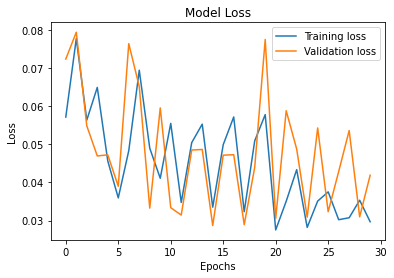

In [17]:
#Viewing the training and validation loss
plt.plot(trained_model.history['loss'], label='Training loss')
plt.plot(trained_model.history['val_loss'], label='Validation loss')
plt.title(label='Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [18]:
#Running the model on the test data
model.evaluate(test_sequences, test_sp)

13/13 [==============================] - 3s 15ms/step - loss: 0.0554


0.055417146533727646

### Detecting anomalies

To detect anomalies, I will do the following:
   
    (1) Subtract the predicted stock prices for the training data from the actual stock prices to find loss
    
    (2) Derive an anomaly threshold value from the training data for the reconstruction loss
    
    (3) Subtract the predicted stock prices for the test data from the actual stock prices
    
    (4) Isolate all dates from the test data that have a loss greater than or equal to the previously derived threshold value

In [19]:
#Finding training loss
pred_seq_train = model.predict(train_sequences, verbose=0)
training_loss = np.mean(np.abs(pred_seq_train - train_sequences), axis=1)

#Viewing the loss  with a histogram
fig = px.histogram(training_loss,nbins=40)
fig.update_layout(
    title="Training Reconstruction Loss",
    xaxis_title="Loss",
    yaxis_title="Count",
    showlegend=False
)
fig.show()

In [20]:
#Calculating the threshold
quintile = 99
threshold = np.percentile(training_loss,quintile)
print("The loss threshold value is ",threshold)

The loss threshold value is  0.08453584196255817


I have set a very rigid threshold loss value by setting a high quintile value of 99. My aim is not to find as many anamolies as possible but simply to identify true anamolies. Setting a rigid threshold value increases the chance that the identified anamolies actually are anamolies.

In [21]:
#Finding the test loss
pred_seq_test = model.predict(test_sequences, verbose=0)
testing_loss = np.mean(np.abs(pred_seq_test - test_sequences), axis=1)

#Viewing the loss  with a histogram
fig = px.histogram(testing_loss,nbins=40)
fig.update_layout(
    title="Testing Reconstruction Loss",
    xaxis_title="Loss",
    yaxis_title="Count",
    showlegend=False
)
fig.show()

In [22]:
#Finding the anamolies
df = test.copy()
df = test.iloc[30:]
df['Reconstruction Loss'] = testing_loss
anomalies = df[df['Reconstruction Loss']>threshold]
indices = list(anomalies.index)
indices.sort()
anomalies = anomalies.loc[indices]
anomalies

C:\Users\chink\AppData\Local\Temp/ipykernel_20632/282041591.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date  Adj Close  Reconstruction Loss
12037  2020-02-25   0.702315             0.089839
12038  2020-02-26   0.725384             0.098648
12039  2020-02-27   0.707280             0.099689
12040  2020-02-28   0.687423             0.101853
12041  2020-03-02   0.730057             0.105966
...           ...        ...                  ...
12437  2021-09-24   1.146839             0.161074
12438  2021-09-27   1.134753             0.158673
12439  2021-09-28   1.117440             0.157506
12440  2021-09-29   1.133446             0.157260
12441  2021-09-30   1.116460             0.152016

[80 rows x 3 columns]

The model has deteced 80 dates as anomalies. Many of these dates are adjacent in time, meaning that the detected anomalies actually span periods of times. The next code chunk will actually print the start and end dates of these periods of time.

In [23]:
#Finding the start and end dates of the periods of time spanned by the anomalies
l = []
for i in range(len(indices)):
    if i != len(indices)-1:
        if indices[i] != indices[i-1]+1 and indices[i] == indices[i+1]-1: #start of series
            entry = []
            entry.append(indices[i])
        if indices[i] == indices[i-1]+1 and indices[i] != indices[i+1]-1: #end of series
            entry.append(indices[i])
            l.append(entry)
    if i == len(indices)-1 and indices[i] == indices[i-1]+1:
        entry.append(indices[i])
        l.append(entry)
dates = []
for i in l:
    sub_dates = []
    sub_dates.append(anomalies.loc[i[0]]['Date'])
    sub_dates.append(anomalies.loc[i[-1]]['Date'])
    dates.append(sub_dates)
print('The anomalies span the following dates ')
for i in dates:
    print('From\t',i[0],'\tto\t',i[1])

The anomalies span the following dates 
From	 2020-02-25 	to	 2020-03-04
From	 2020-03-13 	to	 2020-03-31
From	 2020-06-16 	to	 2020-07-01
From	 2020-12-09 	to	 2020-12-14
From	 2021-01-04 	to	 2021-01-14
From	 2021-08-12 	to	 2021-09-30


### Comparing the predicted anomalies with the real-world stock data

I will use Yahoo Finance's data on the Pfizer stock to check the accuracy of the predicted anomalies. In each of the charts displayed below, the purple line represents the 30-day moving average, which was selected because the time-step for the model was set to 30. The bars at the bottom indicate the volume traded each day, with red and green indicating increases or decreases in stock price, respectively.

The periods of time highlighted in light red represent represent the anomalies detected by the LSTM model. The dates highlighted in light blue indicate days with high volume. The idea behind taking notice of the volume bars is that large volumes can signify high buying or selling pressure, which drives large increases and decreases in stock price (respectively) and causes anomalies in the stock price as a result. For the purposes of this notebook, I will assume large volume changes to be indicative of anomalies to qualitatively assess the performance of the model.

Jan to April 2020
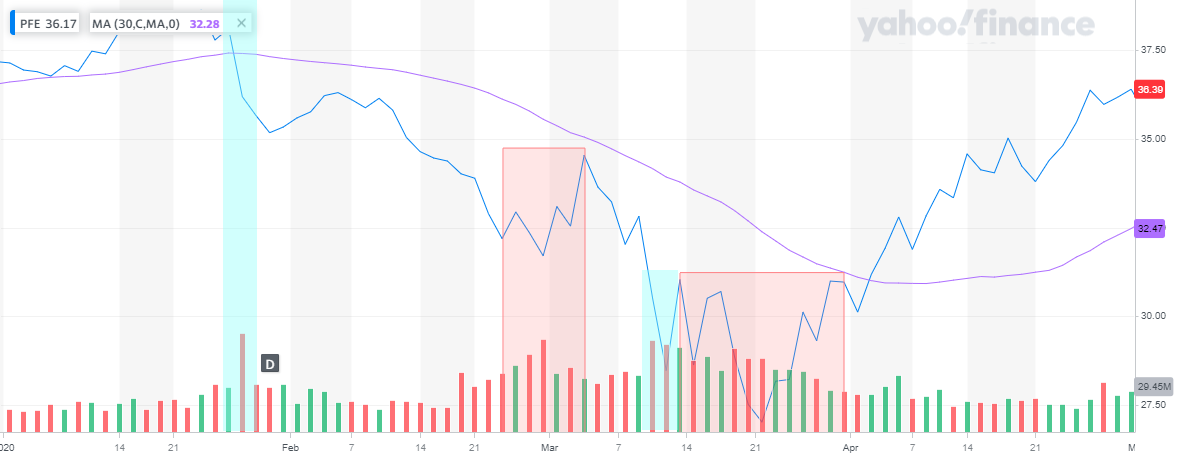

May to August 2020
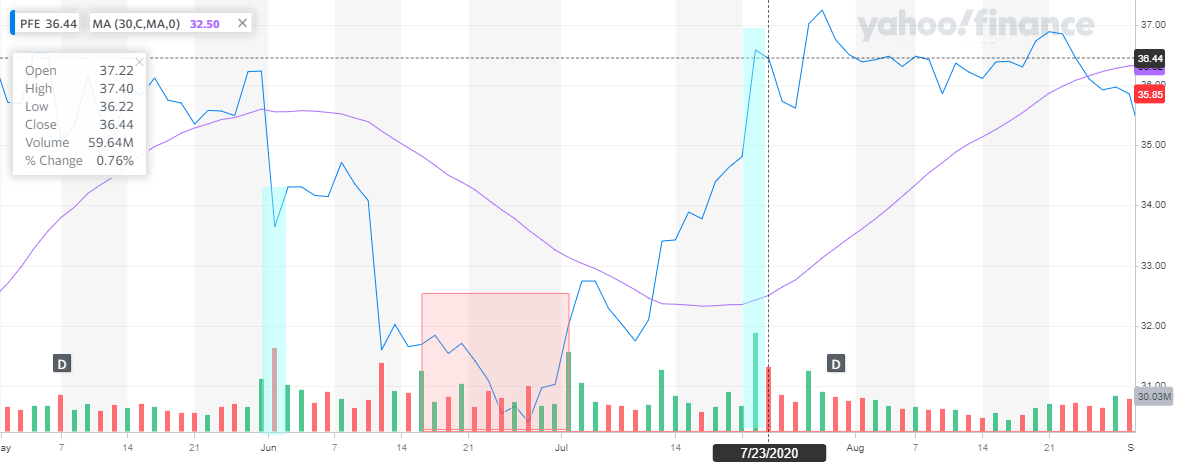

September to December 2020
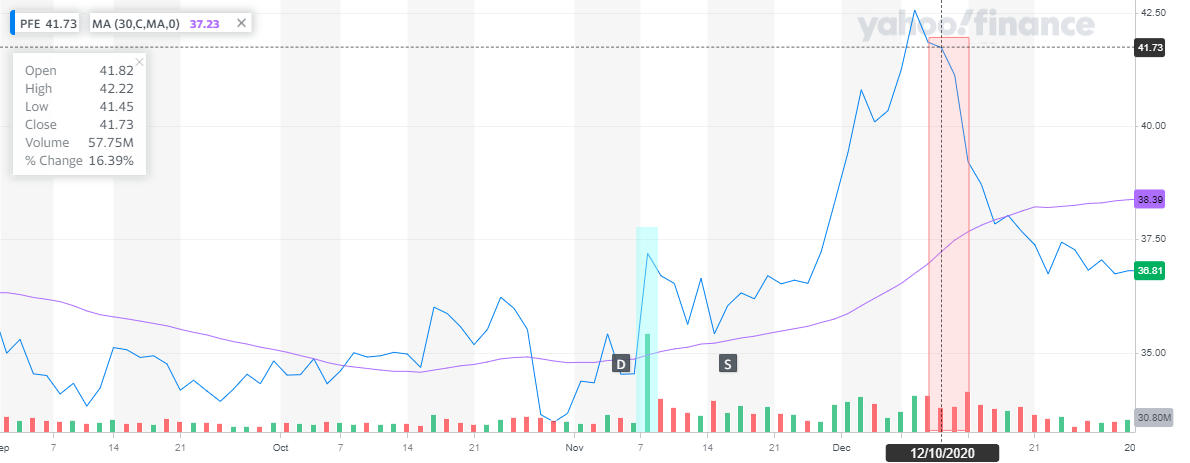

Jan to April 2021
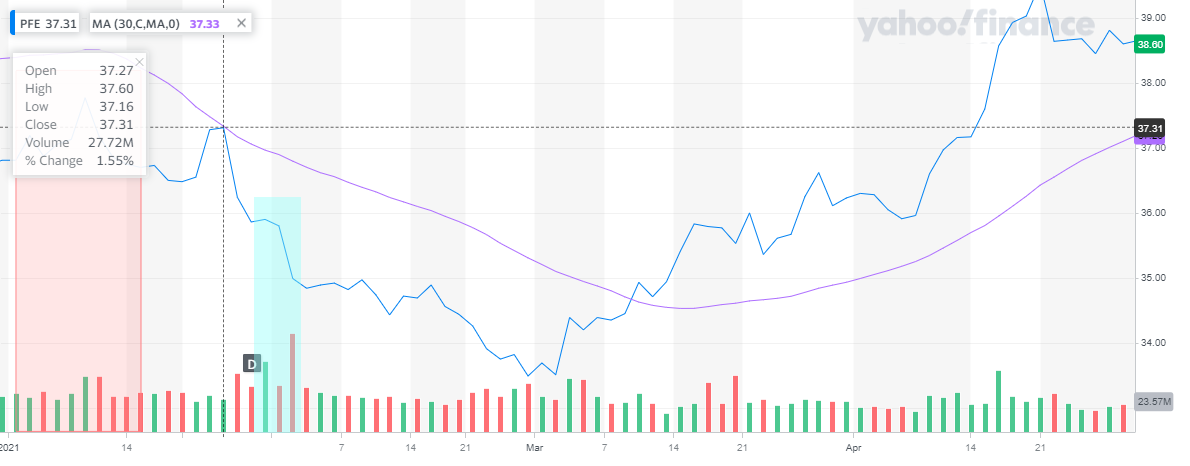

May to September 2021
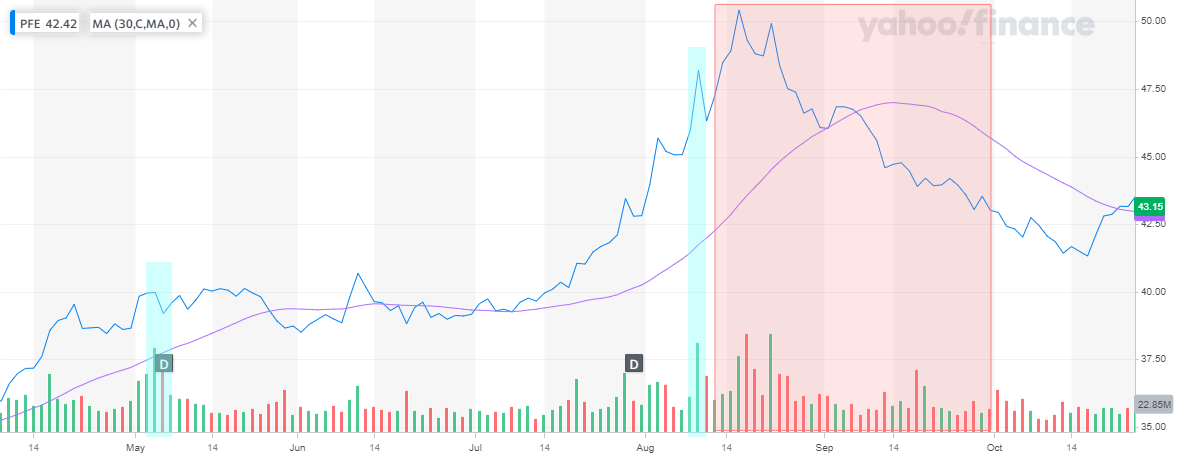

It can be seen from the charts above that in most of the time periods identified by the model as anomalies, there do exist large changes in trading volume. An exception to this the period of time from 12/09/20 to 12/14/20. Throughout 2020 and 2021, the autoencoder does seem to miss large changes in trading volume as well; some of the missed anomalies have trading volumes that outweigh those of the anomalies detected by the model (i.e. Sep-Dec 2020). Additionally, it is important to note that while the model does correctly predict periods of time in which there are anomalies, not every day in this period of time is an anomaly. All in all, in the context of forecasting the model shows mediocre performance. It may be useful in identifying periods of time during which one will observe anomalies, but it is not effective in predicting every anomaly or the largest anomalies during a period of time. More investigation is required to make this LSTM model more effective.

### References

    1. https://github.com/TareqTayeh/Price-TimeSeries-Anomaly-Detection-with-LSTM-Autoencoders-Keras/blob/master/code/Time%20Series%20of%20Price%20Anomaly%20Detection%20with%20LSTM%20Autoencoders%20(Keras).ipynb
    
    2. https://www.kaggle.com/varpit94/pfizer-stock-data
    
    3. https://machinelearningmastery.com/lstm-autoencoders/
    
    4. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
    
    5. https://finance.yahoo.com/quote/PFE?p=PFE&.tsrc=fin-srch